### Apartment Image Registration Dev

In [1]:
%run -m celldom.nb.logging
import os
import os.path as osp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from celldom.core import cytometry
from celldom.config import experiment_config
from celldom.extract import ALL_IMAGES
from celldom.nb import vizutils
import celldom
plt.gray()
None

In [2]:
config = experiment_config.ExperimentConfig(celldom.get_config('experiment', 'exp-20181013-G1v2-K562-imatinib'))

In [3]:
img_path = '2018-10-13-G1-K562-Orange-2-Imatinib-150nM-24hr/BFF_16X_St_048_Apt_008_201810141311.tif'
img_path = osp.join(celldom.get_data_dir(), 'dataset', 'dataset08', img_path)
img_path

'/lab/data/celldom/dataset/dataset08/2018-10-13-G1-K562-Orange-2-Imatinib-150nM-24hr/BFF_16X_St_048_Apt_008_201810141311.tif'

In [4]:
acq = cytometry.Acquisition(config, img_path)
img = acq.load_image()
img.dtype, img.shape

(dtype('uint8'), (750, 1000, 3))

In [5]:
def get_cytometer(**kwargs):
    output_dir = '/tmp/cytometry_debug'
    if osp.exists(output_dir):
        !rm -rf /tmp/cytometry_debug/*
    cytometer = cytometry.Cytometer(config, output_dir, **kwargs)
    cytometer.initialize()
    return cytometer

In [6]:
cytometer = get_cytometer(enable_registration=False)

Using TensorFlow backend.


In [7]:
%%time
acq_data, apt_data, cell_data = cytometer.analyze(acq, dpf=ALL_IMAGES)

CPU times: user 6.77 s, sys: 7.08 s, total: 13.8 s
Wall time: 5.79 s


In [8]:
apt_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8 entries, 0 to 7
Data columns (total 32 columns):
acq_apartment           8 non-null object
acq_cell_line           8 non-null object
acq_color               8 non-null object
acq_concentration       8 non-null object
acq_condition           8 non-null object
acq_datetime            8 non-null datetime64[ns]
acq_drug                8 non-null object
acq_hour                8 non-null object
acq_id                  8 non-null object
acq_processed_at        8 non-null datetime64[ns]
acq_street              8 non-null object
apt_id                  8 non-null int64
apt_image               8 non-null object
apt_image_height        8 non-null int64
apt_image_width         8 non-null int64
apt_num                 8 non-null object
apt_num_digit_images    8 non-null object
apt_num_digit_scores    8 non-null object
apt_num_image           8 non-null object
cell_count              8 non-null int64
focus_score             8 non-null float64
mark

((204, 181), dtype('uint8'))

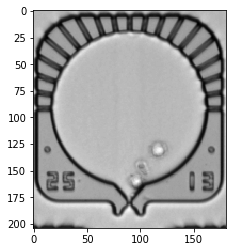

In [9]:
img_patch = cytometer.chip_config.get_template_image()
plt.imshow(img_patch)
img_patch.shape, img_patch.dtype

((204, 181, 3), dtype('uint8'))

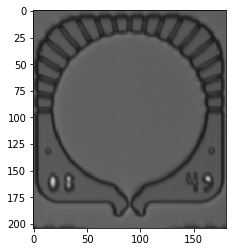

In [10]:
img = apt_data['apt_image'].iloc[0]
plt.imshow(img)
img.shape, img.dtype

Original: (204, 181, 3) uint8
Result: (204, 181, 3) uint8
Shifts: [ 0 -3]
Error: 0.11483475876575491


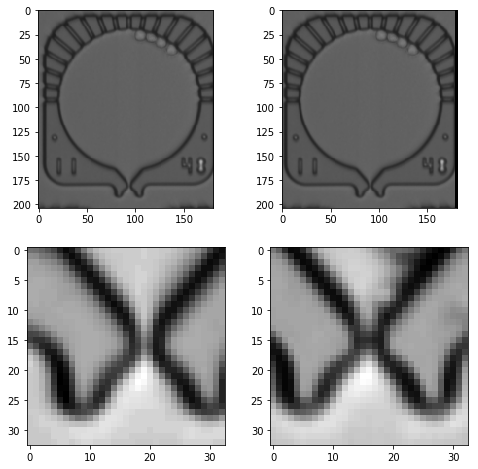

In [11]:
from celldom.extract import apartment_extraction
from scipy import ndimage

r = apt_data.iloc[7]
shifts, error, (ref_patch, tgt_patch) = apartment_extraction.get_apartment_image_translation(r['apt_image'], config.get_chip_config())
img_trans = ndimage.interpolation.shift(r['apt_image'], tuple(shifts) + (0,), order=0, mode='constant', cval=0)

print('Original:', r['apt_image'].shape, r['apt_image'].dtype)
print('Result:', img_trans.shape, img_trans.dtype)
print('Shifts:', shifts)
print('Error:', error)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(r['apt_image'])
axs[0, 1].imshow(img_trans)
axs[1, 0].imshow(tgt_patch)
axs[1, 1].imshow(ref_patch)
fig.set_size_inches(8, 8)

In [12]:
# Re-run with registration on and check digit images
cytometer.enable_registration = True
_, apt_data_reg, _ = cytometer.analyze(acq, dpf=ALL_IMAGES)

In [18]:
apt_data.filter(regex='registration|cell_count')

,cell_count,registration_error,registration_shift_x,registration_shift_y
0,0,0.0,0,0
1,0,0.0,0,0
2,0,0.0,0,0
3,2,0.0,0,0
4,2,0.0,0,0
5,2,0.0,0,0
6,2,0.0,0,0
7,4,0.0,0,0


In [17]:
apt_data_reg.filter(regex='registration|cell_count')

,cell_count,registration_error,registration_shift_x,registration_shift_y
0,0,0.098221,0,-1
1,0,0.091623,-1,-1
2,0,0.078782,-1,0
3,2,0.101735,-3,0
4,2,0.115601,-1,-2
5,2,0.103398,-1,-1
6,2,0.103938,-1,-1
7,4,0.114835,-3,0


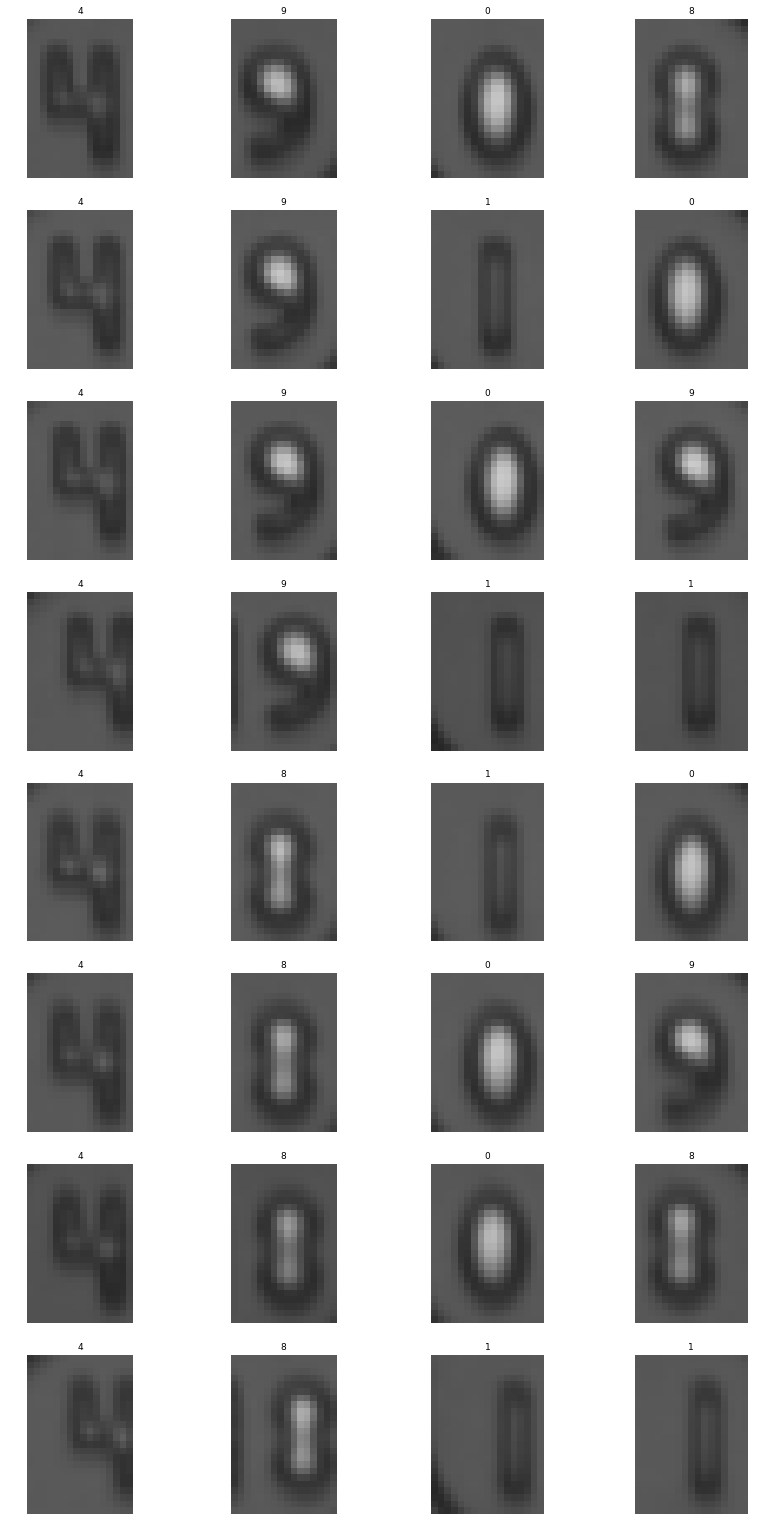

In [15]:
vizutils.display_apartment_digit_images(apt_data, random_state=1, limit=None)

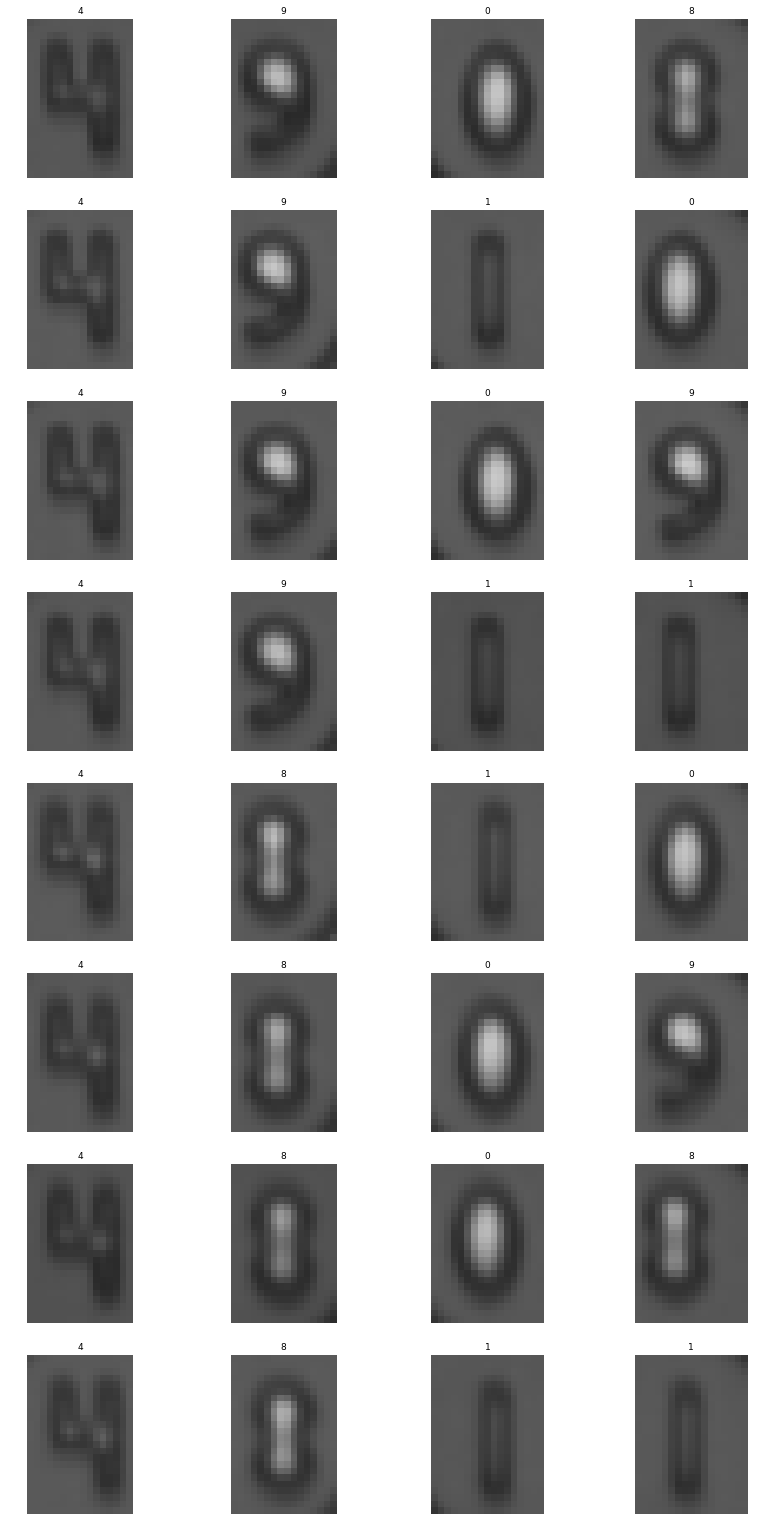

In [16]:
vizutils.display_apartment_digit_images(apt_data_reg, random_state=1, limit=None)